In [127]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 确保3D绘图支持

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

## 1. 定义物理参数 (根据文献 Table I)
使用国际单位制 (SI) 的思想，但保持文献中的单位一致性 (Oe, s, GHz),以便与 gamma 的单位 Oe^-1 s^-1 匹配。时间单位为纳秒 (ns)。

In [ ]:
alpha = 0.02  # Gilbert 阻尼系数 
# gamma 的单位是 1.7 x 10^7 Oe^-1 s^-1。为了在时间单位为 ns 的模拟中使用，
# 需要转换：1.7e7 Oe^-1 s^-1 * (1 s / 1e9 ns) = 1.7e-2 Oe^-1 ns^-1
gamma = 1.7e7 / 1e9  # 旋磁比 (Oe^-1 ns^-1)
H_ext = 200.0  # 外加磁场 (Oe)
H_deg = 8400.0 # 退磁场系数 (Oe)
omega_ac_GHz = 32.0  # 交流频率 (GHz)
omega_ac = omega_ac_GHz * 2 * np.pi # 交流电角频率 (rad/ns)

# 定义固定的矢量方向
e_x = np.array([1.0, 0.0, 0.0])
e_z = np.array([0.0, 0.0, 1.0])

## 2. 定义输入信号 a_j(t) 

In [129]:
# 每 10 ns 切换一次输入
input_times = np.arange(0, 71, 10)  # [0, 10, 20, ..., 70] ns
# 随机二进制输入，长度与 input_times 匹配
adc_values = np.array([200, 100, 200, 200, 100, 200, 100, 200])

a_ac = 26.0

def get_aj(t):
    idx = np.searchsorted(input_times, t, side='right') - 1
    idx = min(idx, len(adc_values) - 1)
    a_dc = adc_values[idx]
    a_j = a_dc + a_ac * np.cos(omega_ac * t)
    return a_j


## 3. 定义 LLG 方程的微分形式 d(m)/dt

In [ ]:
def llg_equation(t, m):
    """
    定义 LLG 方程 d(m)/dt = f(t, m)。
    这是 solve_ivp 需要的函数形式。
    m 是一个包含 [mx, my, mz] 的数组。
    """
    # 确保 m 是单位矢量 (数值求解过程中可能产生微小误差)
    m = m / np.linalg.norm(m)

    H_eff = H_ext * e_x - H_deg * m[2] * e_z

    a_j_t = get_aj(t)

    # dm/dt = 1/(1+alpha^2) * ( T_field + T_stt + alpha*m x (T_field + T_stt) )
    # 其中 T_field 是场引起的力矩，T_stt 是自旋转移力矩
  
    # 场力矩项
    T_field = -gamma * np.cross(m, H_eff)
  
    # 自旋转移力矩 (STT) 项
    T_stt = gamma * a_j_t * np.cross(m, np.cross(m, e_x))
  
    # 总力矩
    T_total = T_field + T_stt
  
    # dm/dt 表达式
    dmdt = (1 / (1 + alpha**2)) * (T_total + alpha * np.cross(m, T_total))
  
    return dmdt


## 4. 设置模拟参数并运行求解器
初始磁化状态 m0 (必须是单位矢量)

不能完全平行于 x 轴，否则场力矩为零，无法启动进动

In [131]:
m0 = np.array([0, 1, 0])
m0 = m0 / np.linalg.norm(m0)

# 定义积分时间区间和采样点
t_span = (0, 70)  # 积分区间 [0, 70] ns
t_eval = np.linspace(t_span[0], t_span[1], 8000)  # 采样点

sol = solve_ivp(
    llg_equation,
    t_span,
    m0,
    method='LSODA',  # 更快的自适应方法
    t_eval=t_eval,
    rtol=1e-7,       # 容差可适当放宽
    atol=1e-8,
    dense_output=False
)
print("求解完成。")


求解完成。


## 5. 可视化结果

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_46814/2171955932.py:12: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(t, aac_plot, label='$a_{ac} \cos(\omega_{ac} t)$', color='r', linestyle='--')
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_46814/2171955932.py:13: SyntaxWarning: invalid escape sequence '\c'
  plt.title('输入信号 $a_{dc}(t)$ 与 $a_{ac} \cos(\omega_{ac} t)$', fontsize=14)


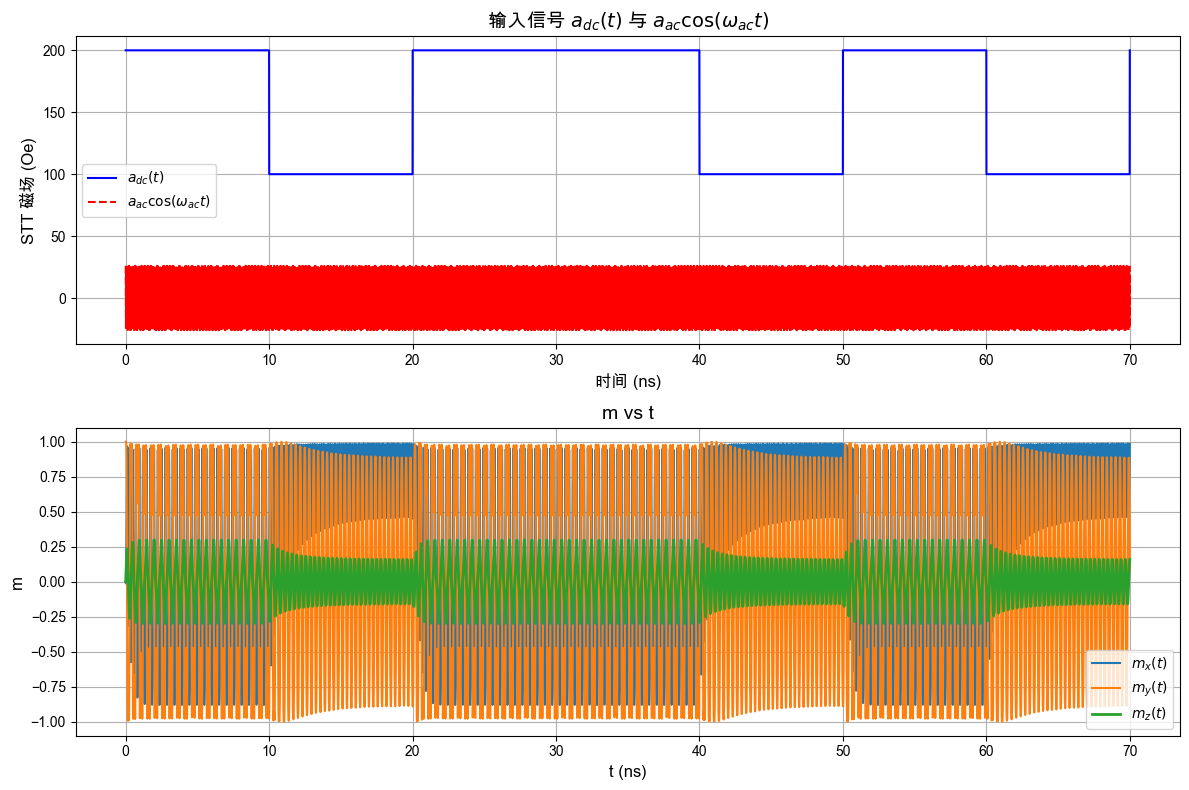

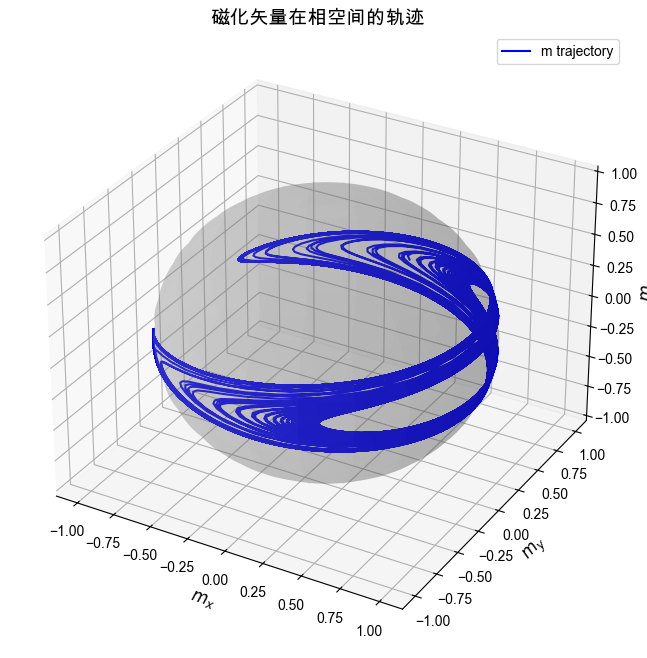

In [ ]:
t = sol.t
mx, my, mz = sol.y

# 绘制 m_x, m_y, m_z 随时间的演化
plt.figure(figsize=(12, 8))

# 绘制输入信号 a_dc(t) 和 a_ac*cos(omega_ac*t)
plt.subplot(2, 1, 1)
adc_plot = [adc_values[np.searchsorted(input_times, time_point, side='right') - 1 if len(input_times) > 1 else 0] for time_point in t]
aac_plot = [a_ac * np.cos(omega_ac * time_point) for time_point in t]
plt.plot(t, adc_plot, label='$a_{dc}(t)$', color='b')
plt.plot(t, aac_plot, label='$a_{ac} \cos(\omega_{ac} t)$', color='r', linestyle='--')
plt.title('输入信号 $a_{dc}(t)$ 与 $a_{ac} \cos(\omega_{ac} t)$', fontsize=14)
plt.xlabel('时间 (ns)', fontsize=12)
plt.ylabel('STT 磁场 (Oe)', fontsize=12)
plt.grid(True)
plt.legend()

# 绘制磁化分量
plt.subplot(2, 1, 2)
plt.plot(t, mx, label='$m_x(t)$')
plt.plot(t, my, label='$m_y(t)$')
plt.plot(t, mz, label='$m_z(t)$', linewidth=2) 
plt.title('m vs t', fontsize=14)
plt.xlabel('t (ns)', fontsize=12)
plt.ylabel('m', fontsize=12)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 绘制三维相空间轨迹图
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(mx, my, mz, label='m trajectory', color='b')
# 绘制一个球体表面作为参考
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='gray', alpha=0.2, rstride=5, cstride=5)

ax.set_xlabel('$m_x$', fontsize=12)
ax.set_ylabel('$m_y$', fontsize=12)
ax.set_zlabel('$m_z$', fontsize=12)
ax.set_title('磁化矢量在相空间的轨迹', fontsize=14)
ax.legend()
plt.show()

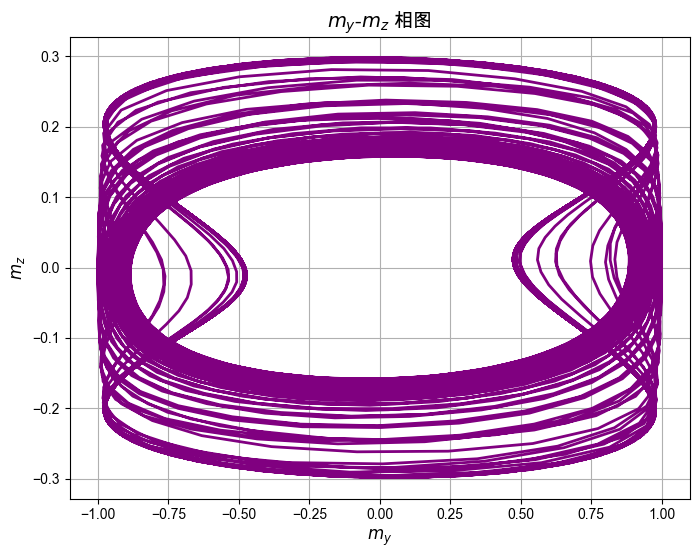

In [133]:

plt.figure(figsize=(8, 6))
plt.plot(my, mz, color='purple', linewidth=2)
plt.xlabel('$m_y$', fontsize=12)
plt.ylabel('$m_z$', fontsize=12)
plt.title('$m_y$-$m_z$ 相图', fontsize=14)
plt.grid(True)
plt.show()

## 研究混沌情况

In [145]:
# 使用已定义的参数 a_ac, a_dc，构造恒定输入信号的 LLG 方程
def ConstantDraw(ac, dc):
    def llg_equation_const(t, m):
        m = m / np.linalg.norm(m)
        H_eff = H_ext * e_x - H_deg * m[2] * e_z
        a_j = dc + ac * np.cos(omega_ac * t)
        T_field = -gamma * np.cross(m, H_eff)
        T_stt = gamma * a_j * np.cross(m, np.cross(m, e_x))
        T_total = T_field + T_stt
        dmdt = (1 / (1 + alpha**2)) * (T_total + alpha * np.cross(m, T_total))
        return dmdt

# 初始磁化状态和积分参数已定义：m0, t_span, t_eval
    sol_const = solve_ivp(
    llg_equation_const,
    t_span,
    m0,
    method='LSODA',
    t_eval=t_eval,
    rtol=1e-7,
    atol=1e-8,
    dense_output=False
)
    mx_const, my_const, mz_const = sol_const.y

    plt.figure(figsize=(8, 6))
    plt.plot(my_const, mz_const, color='green', linewidth=2)
    plt.xlabel('$m_y$', fontsize=12)
    plt.ylabel('$m_z$', fontsize=12)
    plt.title(f'$m_y$-$m_z$ 相图 (a_dc={dc}, a_ac={ac})', fontsize=14)
    plt.grid(True)
    plt.show()


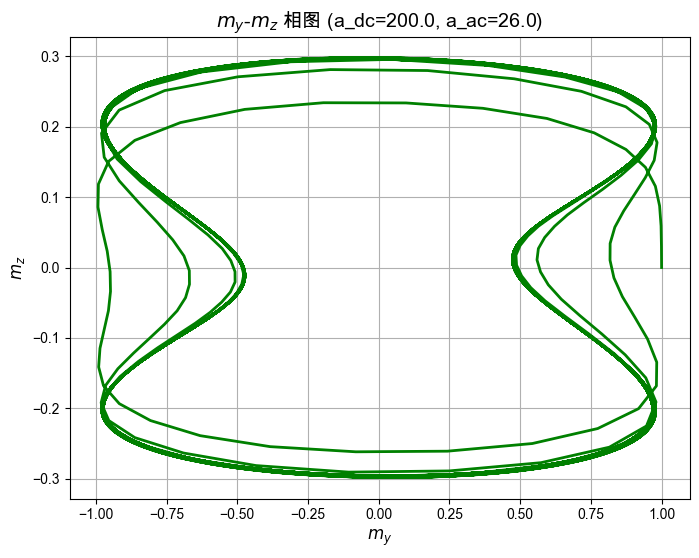

In [146]:
ac = 26.0  # 交流分量的幅值 (Oe)
dc = 200.0  # 假设一个恒定的直流分量 (Oe)
ConstantDraw(ac, dc)

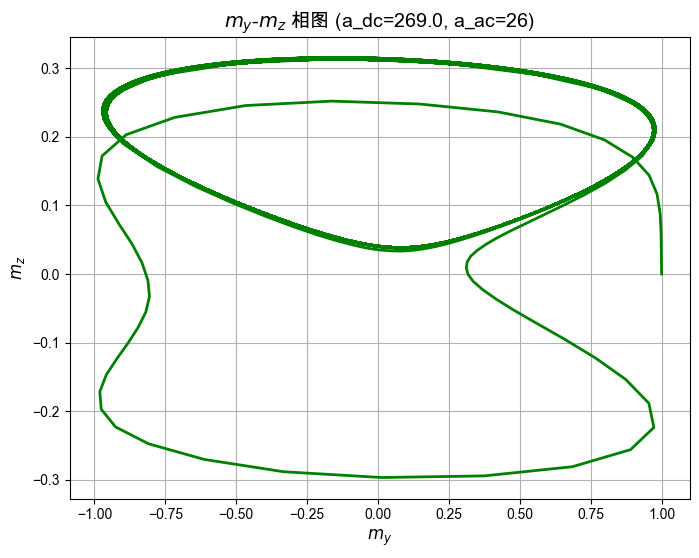

In [149]:
ac = 26  # 交流分量的幅值 (Oe)
dc = 269.0  # 假设一个恒定的直流分量 (Oe)
ConstantDraw(ac, dc)

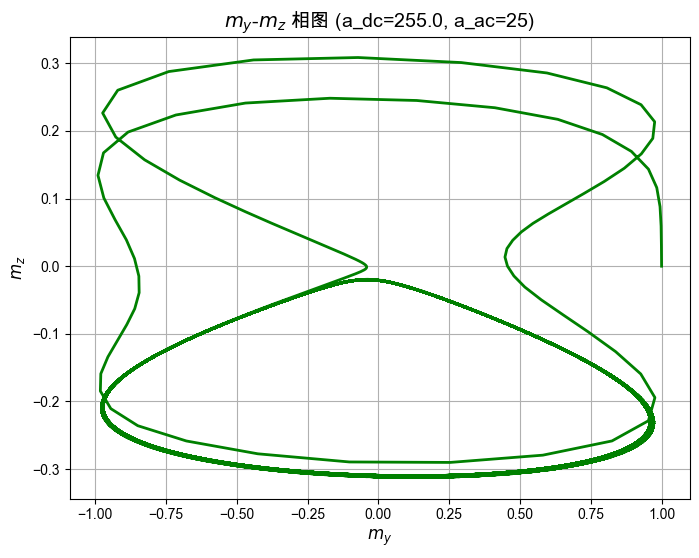

In [156]:
ac = 25  # 交流分量的幅值 (Oe)
dc = 255.0  # 假设一个恒定的直流分量 (Oe)
ConstantDraw(ac, dc)